# ResNet-18 Training and Visualization

This notebook demonstrates the training process of our quantization-friendly ResNet-18 model on the CIFAR-10 dataset. We'll:
1. Train the model with visualization
2. Monitor training metrics
3. Visualize feature maps and activations
4. Save the trained model for quantization

## Setup and Imports
First, let's import all necessary libraries and set up our environment.

In [11]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
import seaborn as sns

# Add project root to path
sys.path.append('..')
from src.models import create_resnet18
from src.utils.data import get_cifar10_data
from src.utils.visualization import plot_training_history

# Set device and random seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

Using device: cuda


## Training Functions
Define helper functions for training and validation.

In [12]:
def train_epoch(model, train_loader, criterion, optimizer, scaler, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Training")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        progress_bar.set_postfix(
            loss=f"{running_loss/total:.4f}",
            acc=f"{100.*correct/total:.2f}%"
        )
    
    return running_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return running_loss / len(val_loader), 100. * correct / total, all_preds, all_targets

## Feature Map Visualization
Define function for visualizing model's feature maps.

In [13]:
def visualize_feature_maps(model, loader, device, num_features=12):
    images, labels = next(iter(loader))
    images = images.to(device)
    
    feature_maps = {}
    hooks = []
    
    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach()
        return hook
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn(name)))
    
    with torch.no_grad():
        _ = model(images[:1])
    
    for hook in hooks:
        hook.remove()
    
    for name, features in feature_maps.items():
        features = features[0].cpu()
        n_features = min(num_features, features.shape[0])
        fig, axes = plt.subplots(3, 4, figsize=(15, 10))
        fig.suptitle(f'Feature Maps: {name}')
        
        for i in range(n_features):
            ax = axes[i//4, i%4]
            im = ax.imshow(features[i], cmap='viridis')
            ax.axis('off')
        
        for i in range(n_features, 12):
            axes[i//4, i%4].axis('off')
        
        plt.tight_layout()
        plt.show()

## Model Training
Create and train the model with progress tracking and visualization.

In [14]:
# Create model and setup training
try:
    # Create model
    model = create_resnet18()
    model = model.to(device)
    print("Model created successfully")
    
    # Training parameters
    num_epochs = 10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create data loaders
    train_loader = get_cifar10_data(batch_size=128, train=True)
    val_loader = get_cifar10_data(batch_size=128, train=False)
    
    # Training loop
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'lr': []
    }
    
    best_acc = 0
    os.makedirs('../models', exist_ok=True)
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion,
            optimizer, scaler, device, epoch
        )
        
        # Validate
        val_loss, val_acc, val_preds, val_targets = validate(
            model, val_loader, criterion, device
        )
        
        # Update learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), '../models/resnet18_cifar10.pth')
            print(f"New best model saved! Accuracy: {best_acc:.2f}%")
    
except Exception as e:
    print(f"Error during training: {str(e)}")

Model created successfully


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 1/10:
Train Loss: 1.9633, Train Acc: 29.48%
Val Loss: 1.5983, Val Acc: 40.29%
Learning Rate: 0.097553
New best model saved! Accuracy: 40.29%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 2/10:
Train Loss: 1.4459, Train Acc: 46.83%
Val Loss: 1.3900, Val Acc: 49.40%
Learning Rate: 0.090451
New best model saved! Accuracy: 49.40%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 3/10:
Train Loss: 1.1751, Train Acc: 57.89%
Val Loss: 1.0667, Val Acc: 62.94%
Learning Rate: 0.079389
New best model saved! Accuracy: 62.94%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 4/10:
Train Loss: 0.9727, Train Acc: 65.38%
Val Loss: 1.0006, Val Acc: 65.11%
Learning Rate: 0.065451
New best model saved! Accuracy: 65.11%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 5/10:
Train Loss: 0.8261, Train Acc: 70.87%
Val Loss: 0.7968, Val Acc: 72.22%
Learning Rate: 0.050000
New best model saved! Accuracy: 72.22%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 6/10:
Train Loss: 0.6820, Train Acc: 76.08%
Val Loss: 0.7684, Val Acc: 73.86%
Learning Rate: 0.034549
New best model saved! Accuracy: 73.86%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 7/10:
Train Loss: 0.5614, Train Acc: 80.46%
Val Loss: 0.6211, Val Acc: 78.69%
Learning Rate: 0.020611
New best model saved! Accuracy: 78.69%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 8/10:
Train Loss: 0.4624, Train Acc: 83.98%
Val Loss: 0.5192, Val Acc: 82.30%
Learning Rate: 0.009549
New best model saved! Accuracy: 82.30%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 9/10:
Train Loss: 0.3868, Train Acc: 86.71%
Val Loss: 0.4295, Val Acc: 85.25%
Learning Rate: 0.002447
New best model saved! Accuracy: 85.25%


Training:   0%|          | 0/391 [00:00<?, ?it/s]


Epoch 10/10:
Train Loss: 0.3326, Train Acc: 88.56%
Val Loss: 0.3970, Val Acc: 86.31%
Learning Rate: 0.000000
New best model saved! Accuracy: 86.31%


## Training Visualization
Plot training metrics and visualize feature maps.

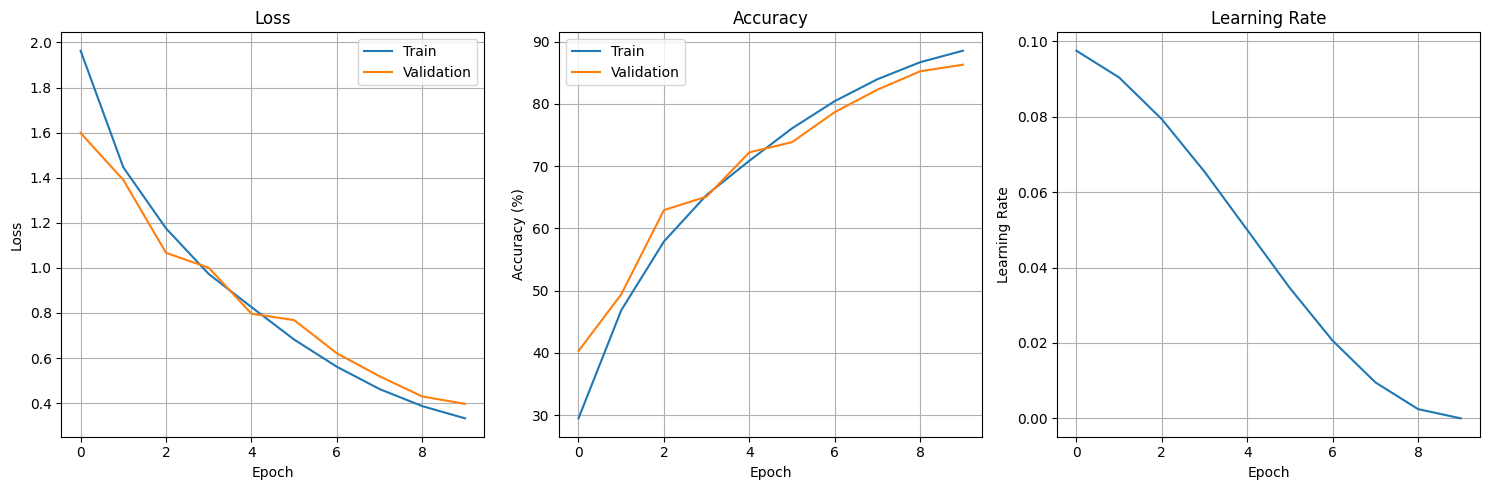


Visualizing feature maps...


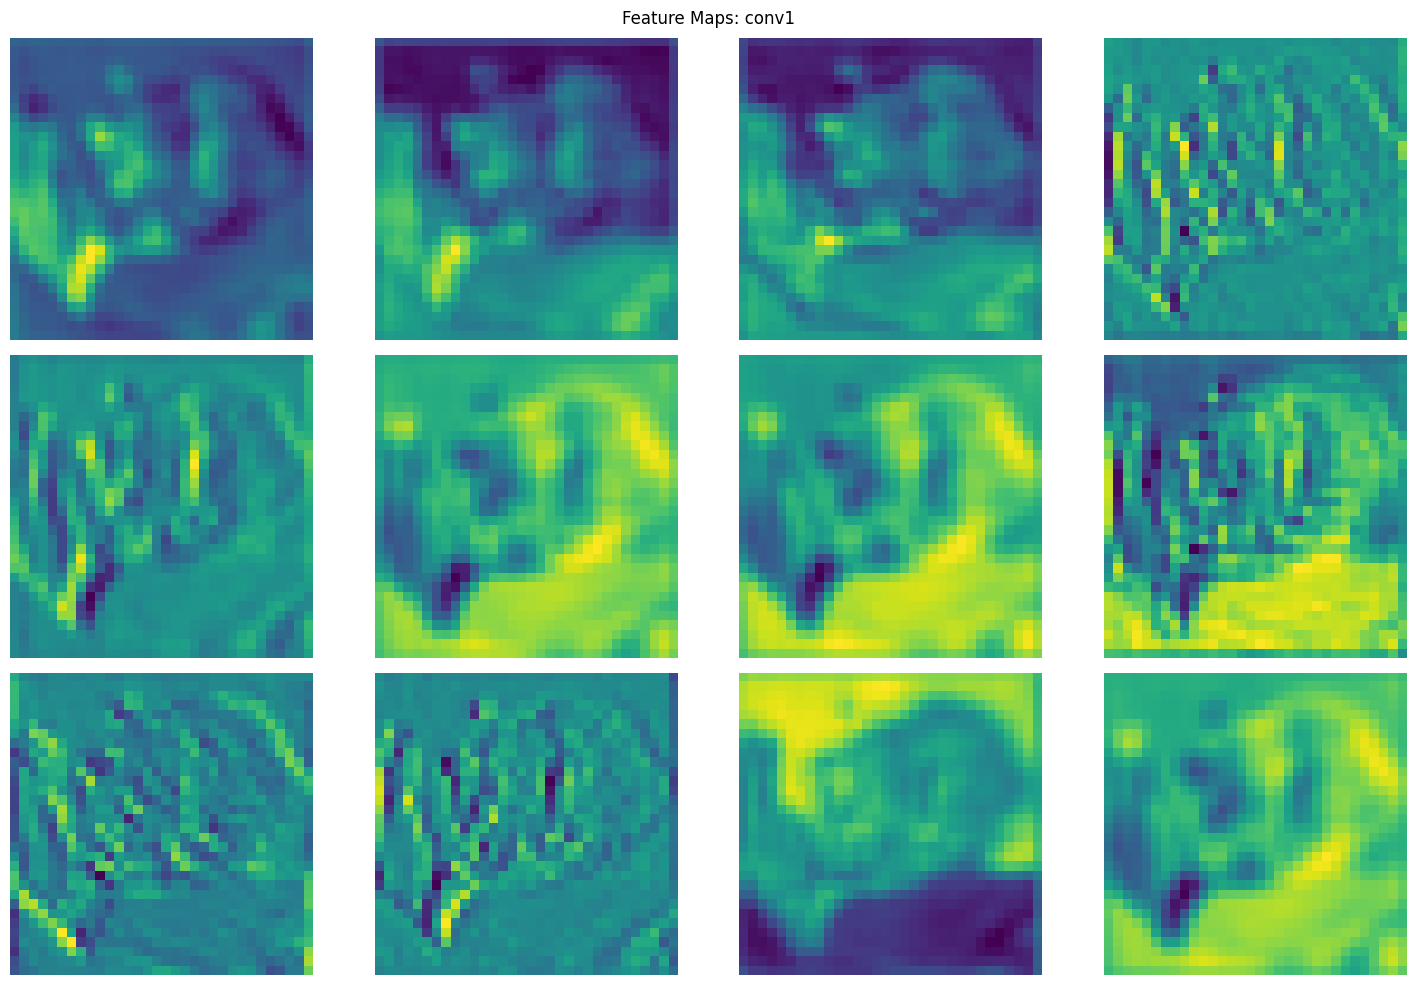

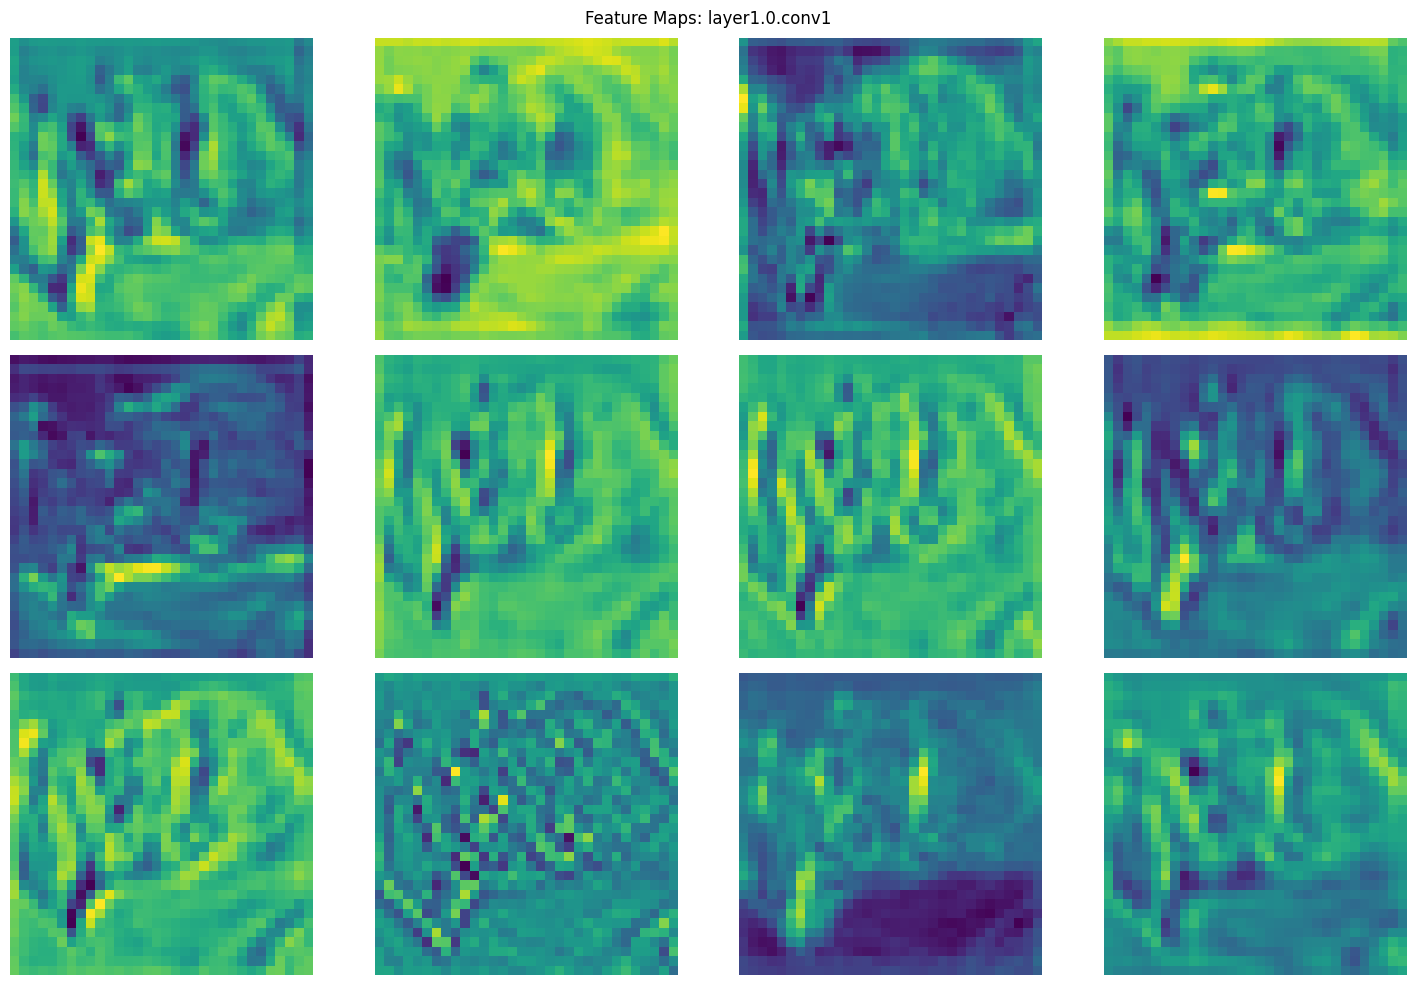

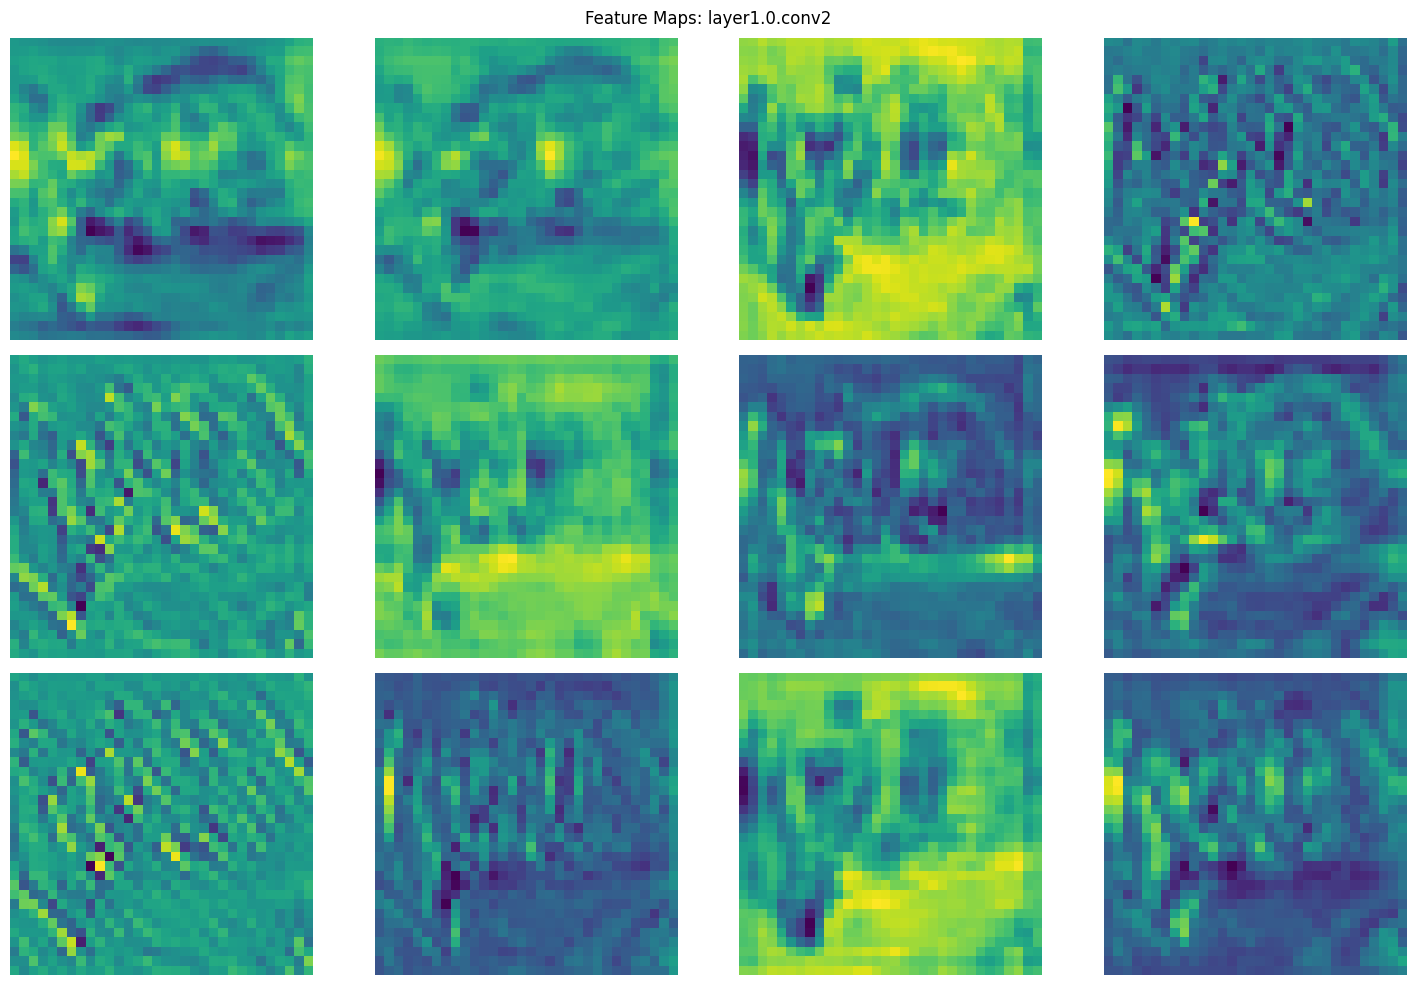

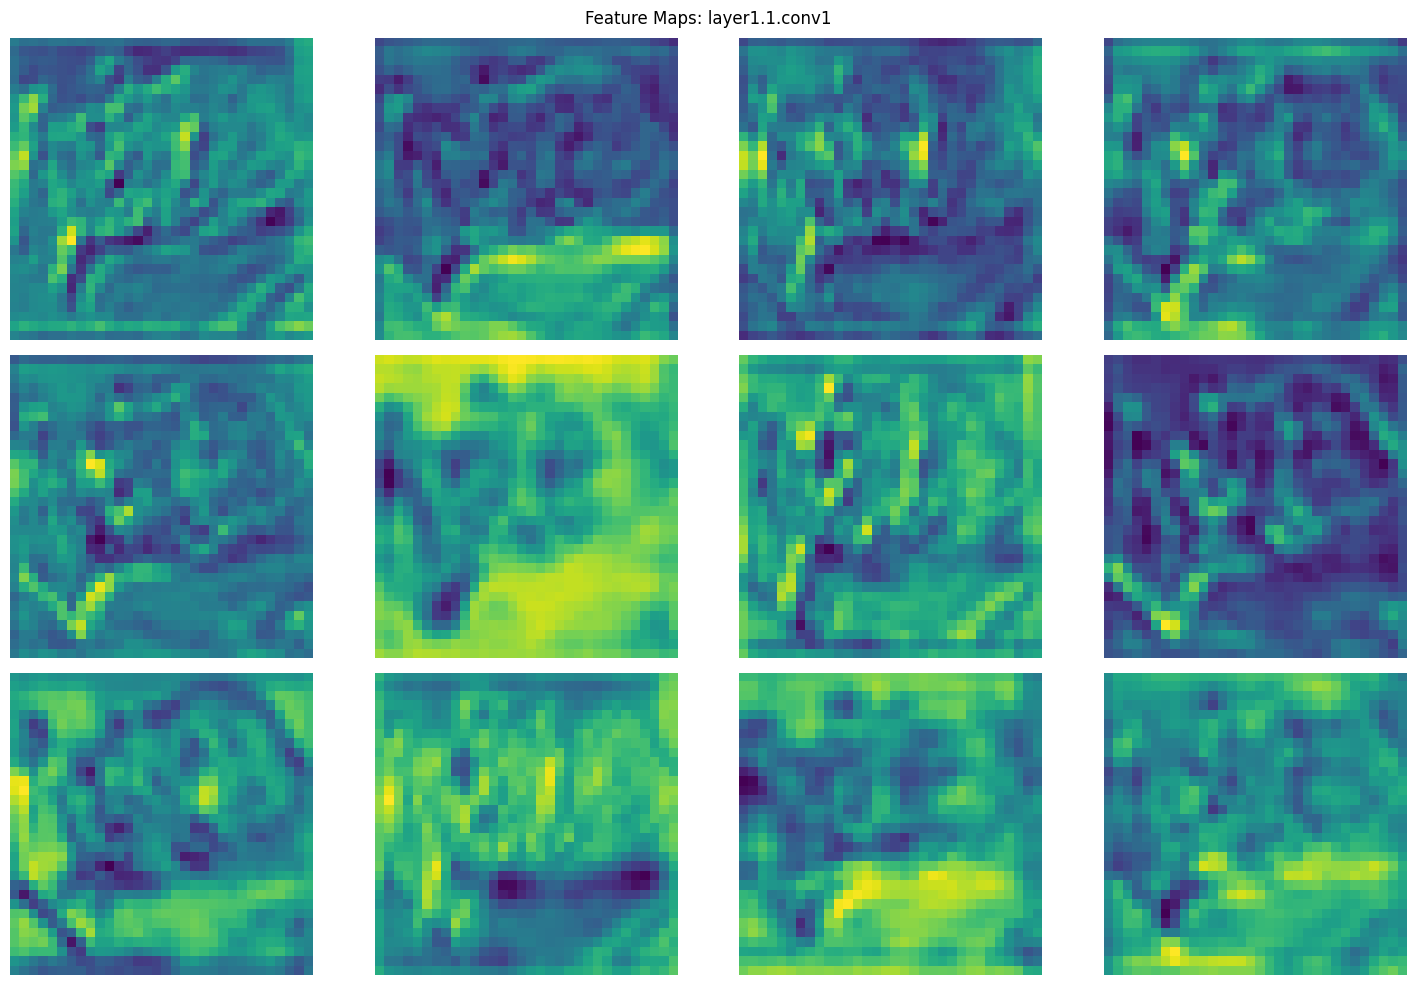

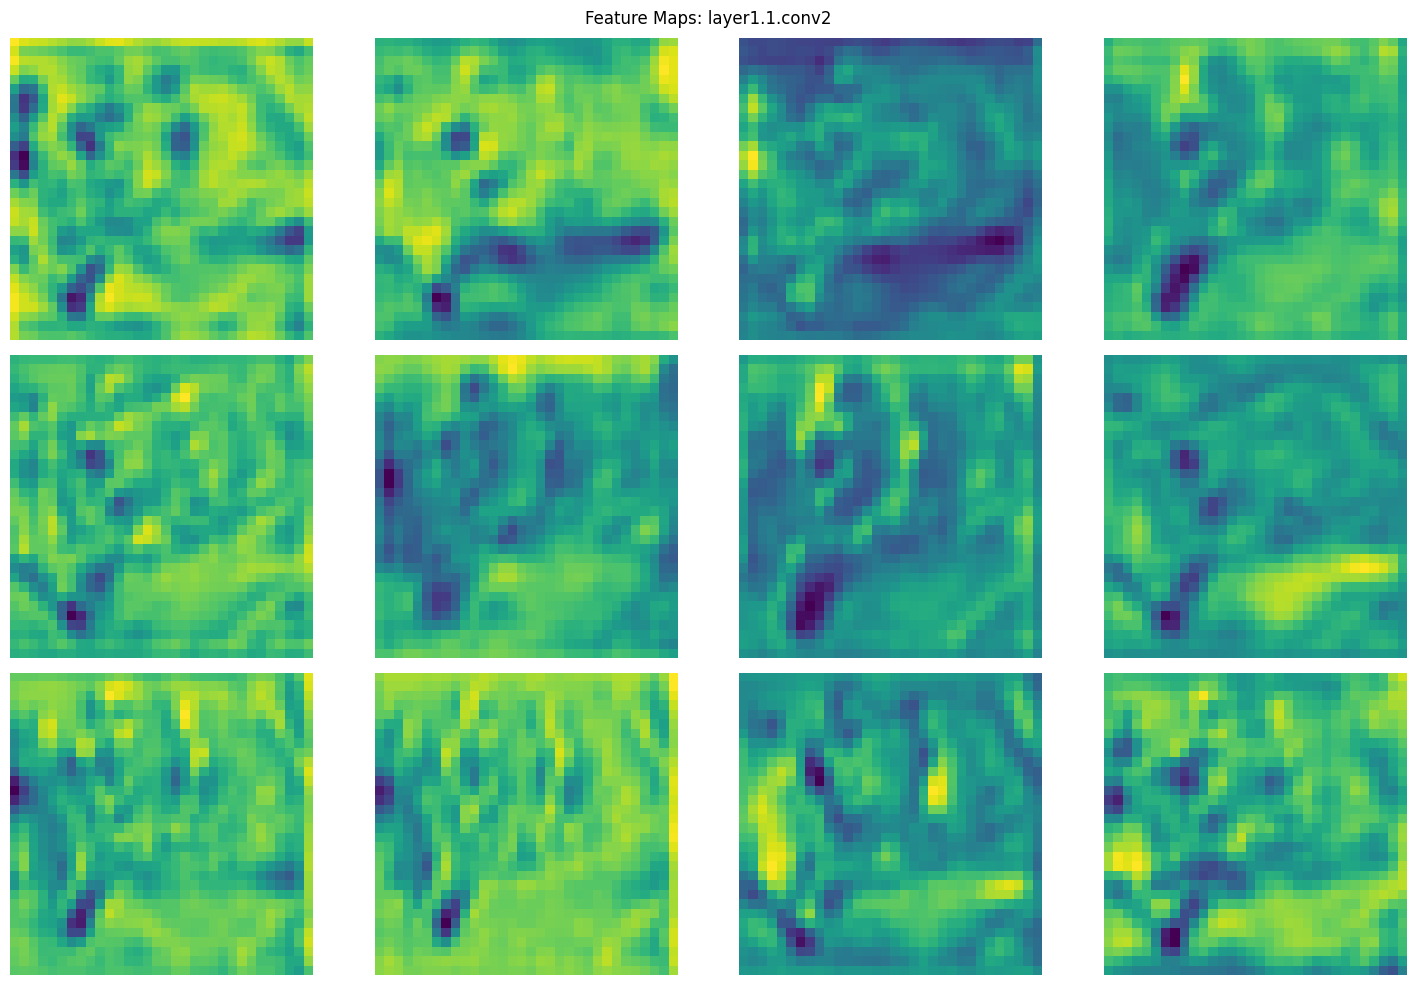

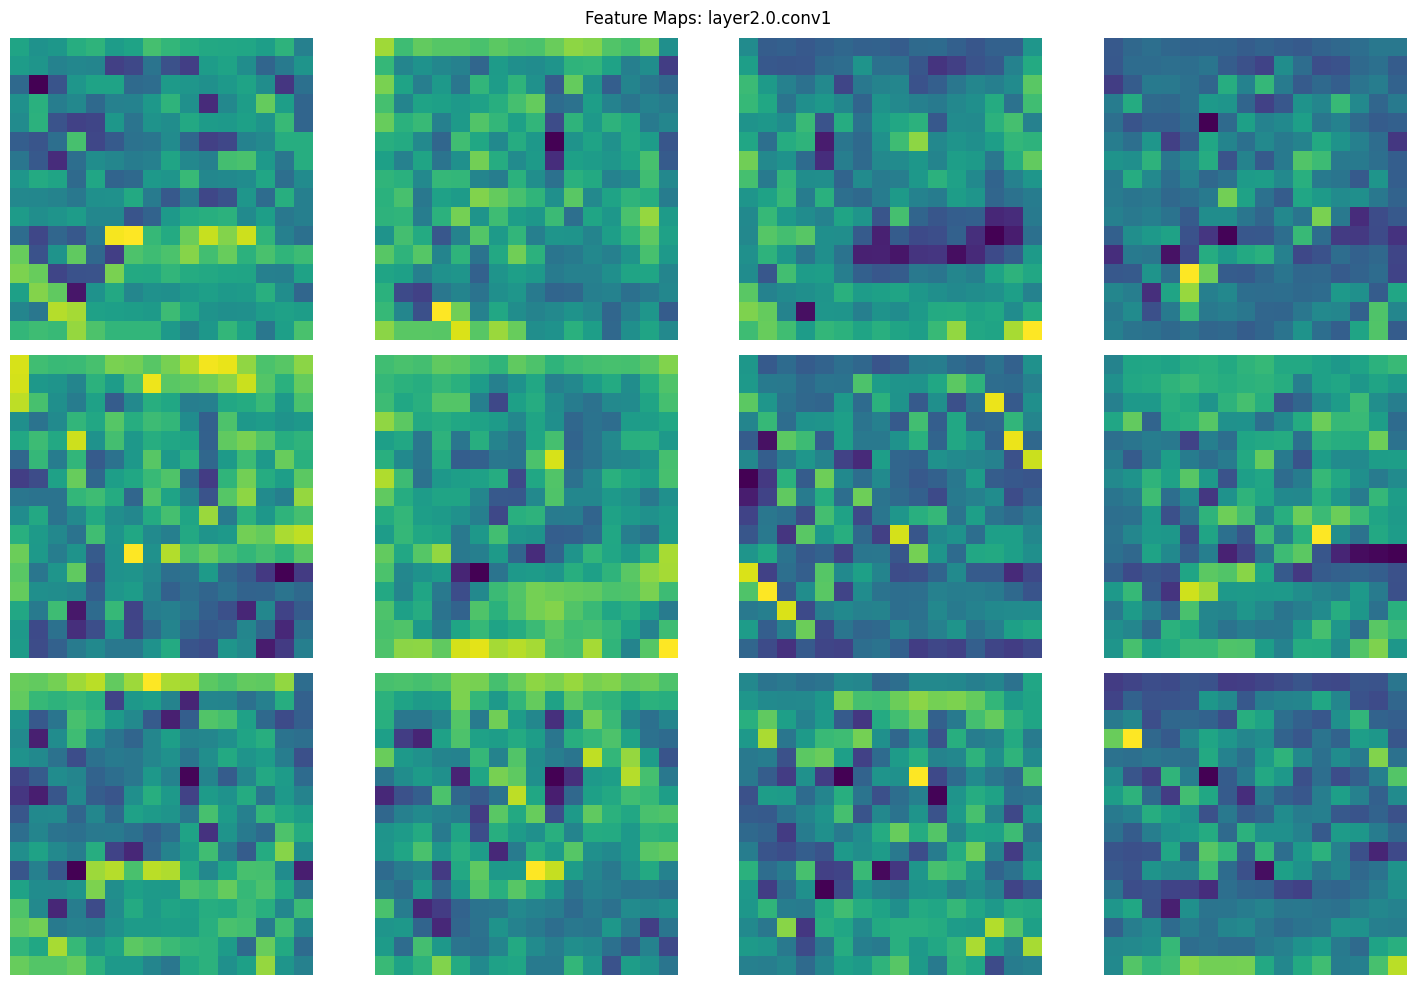

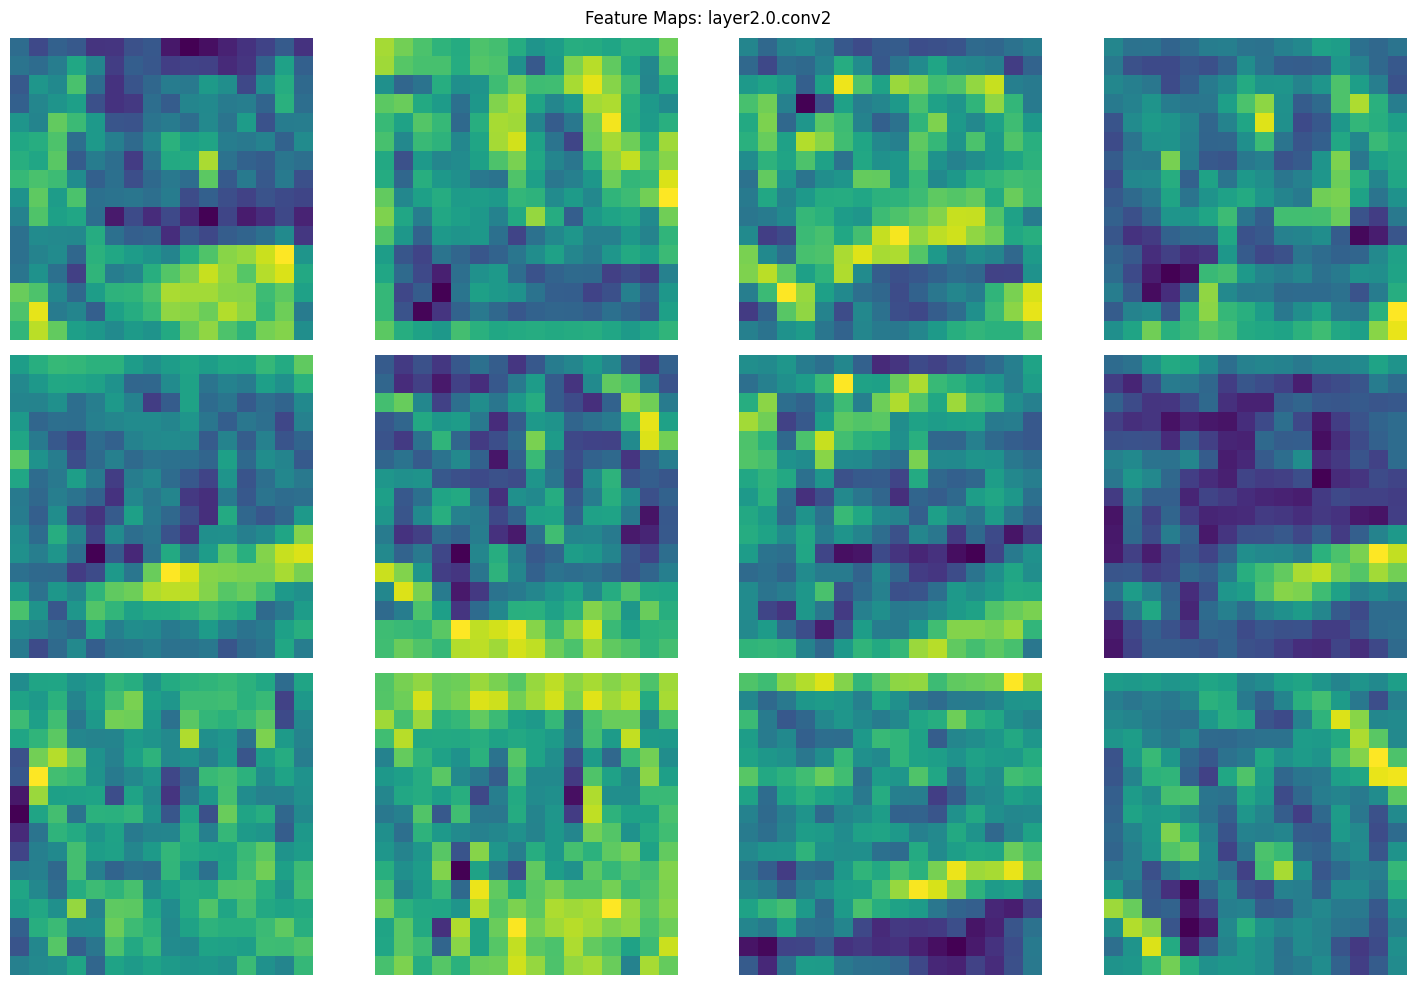

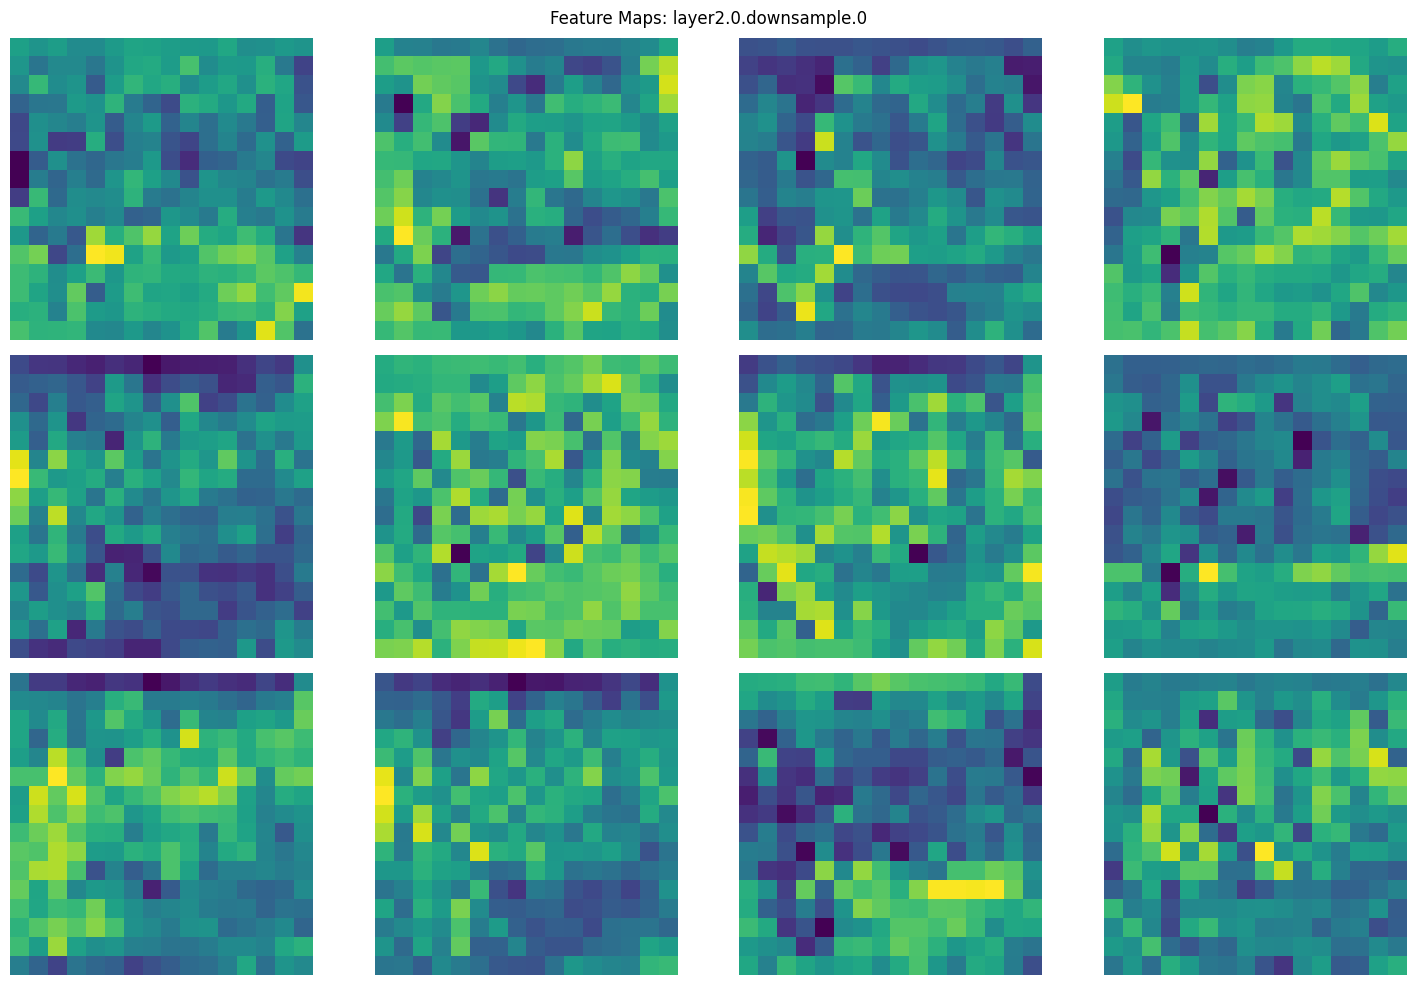

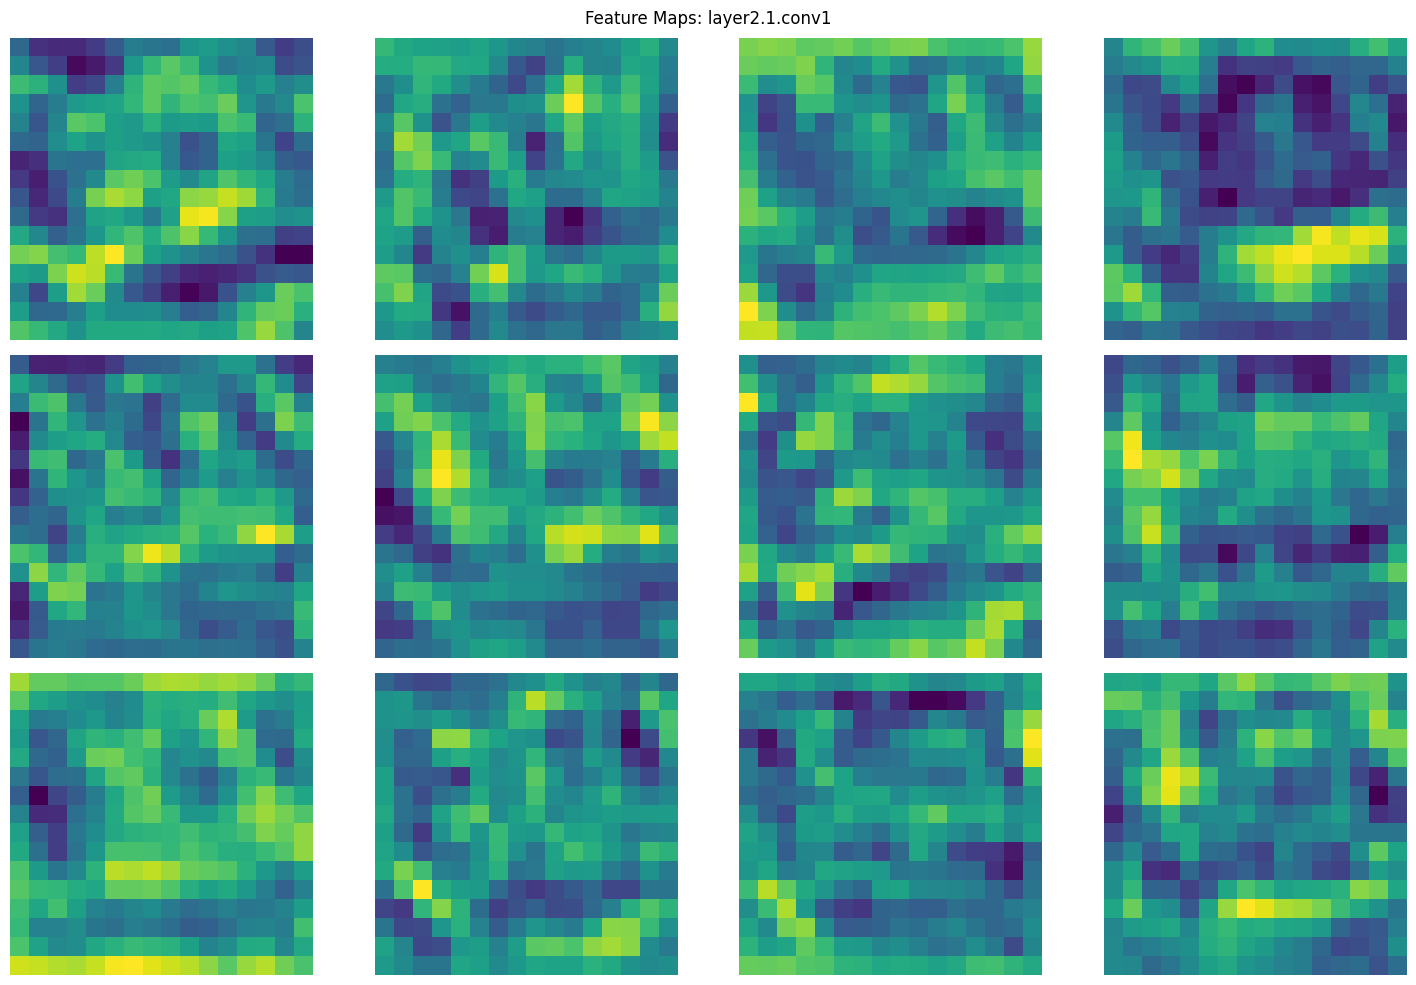

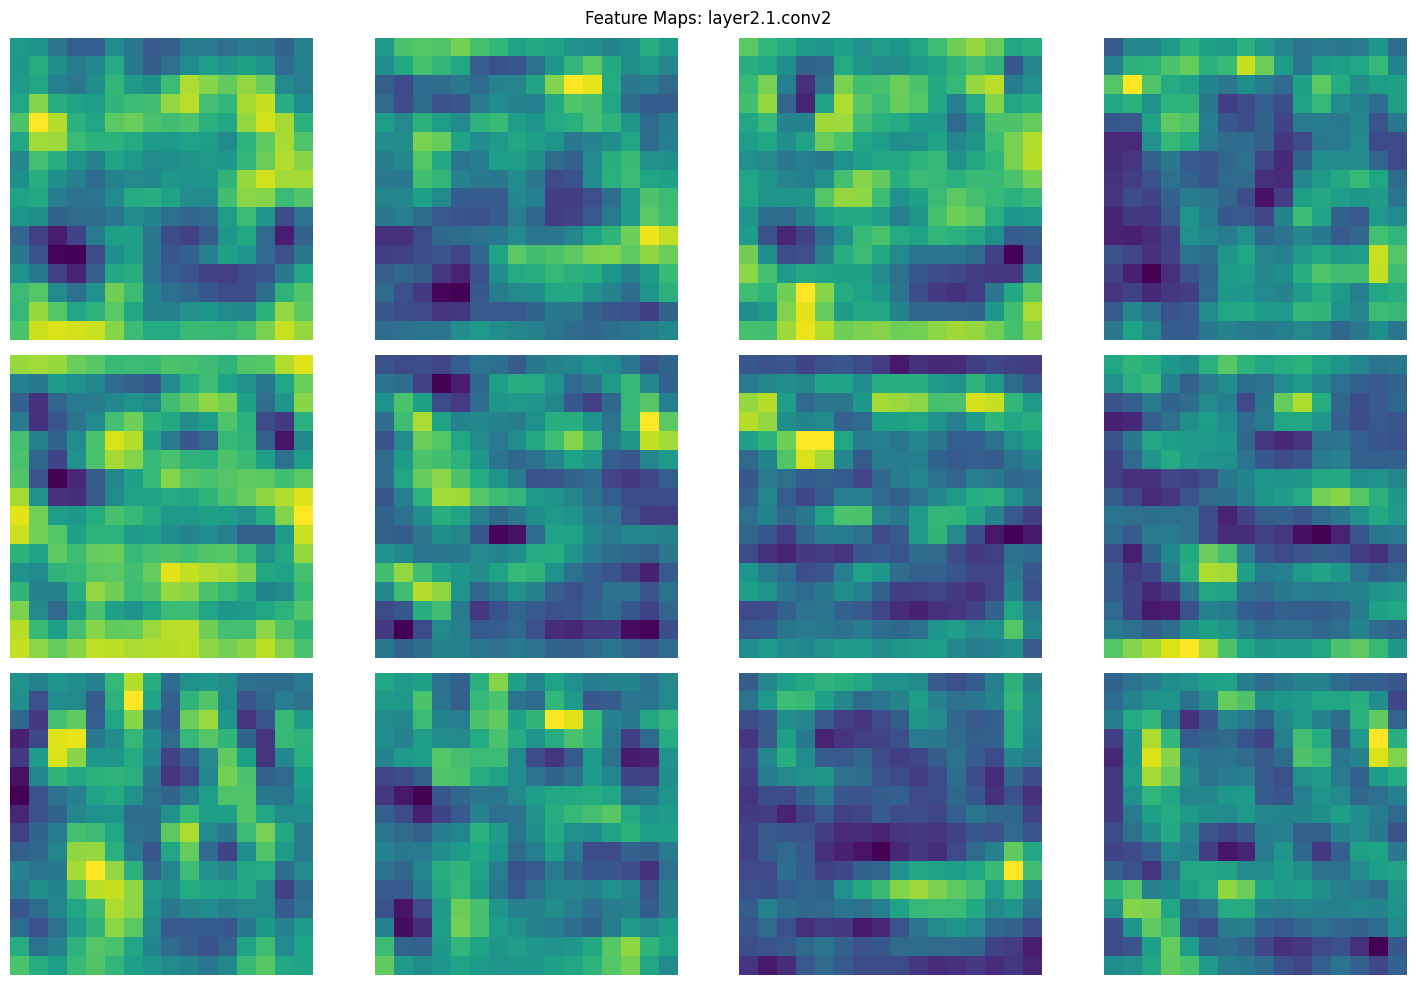

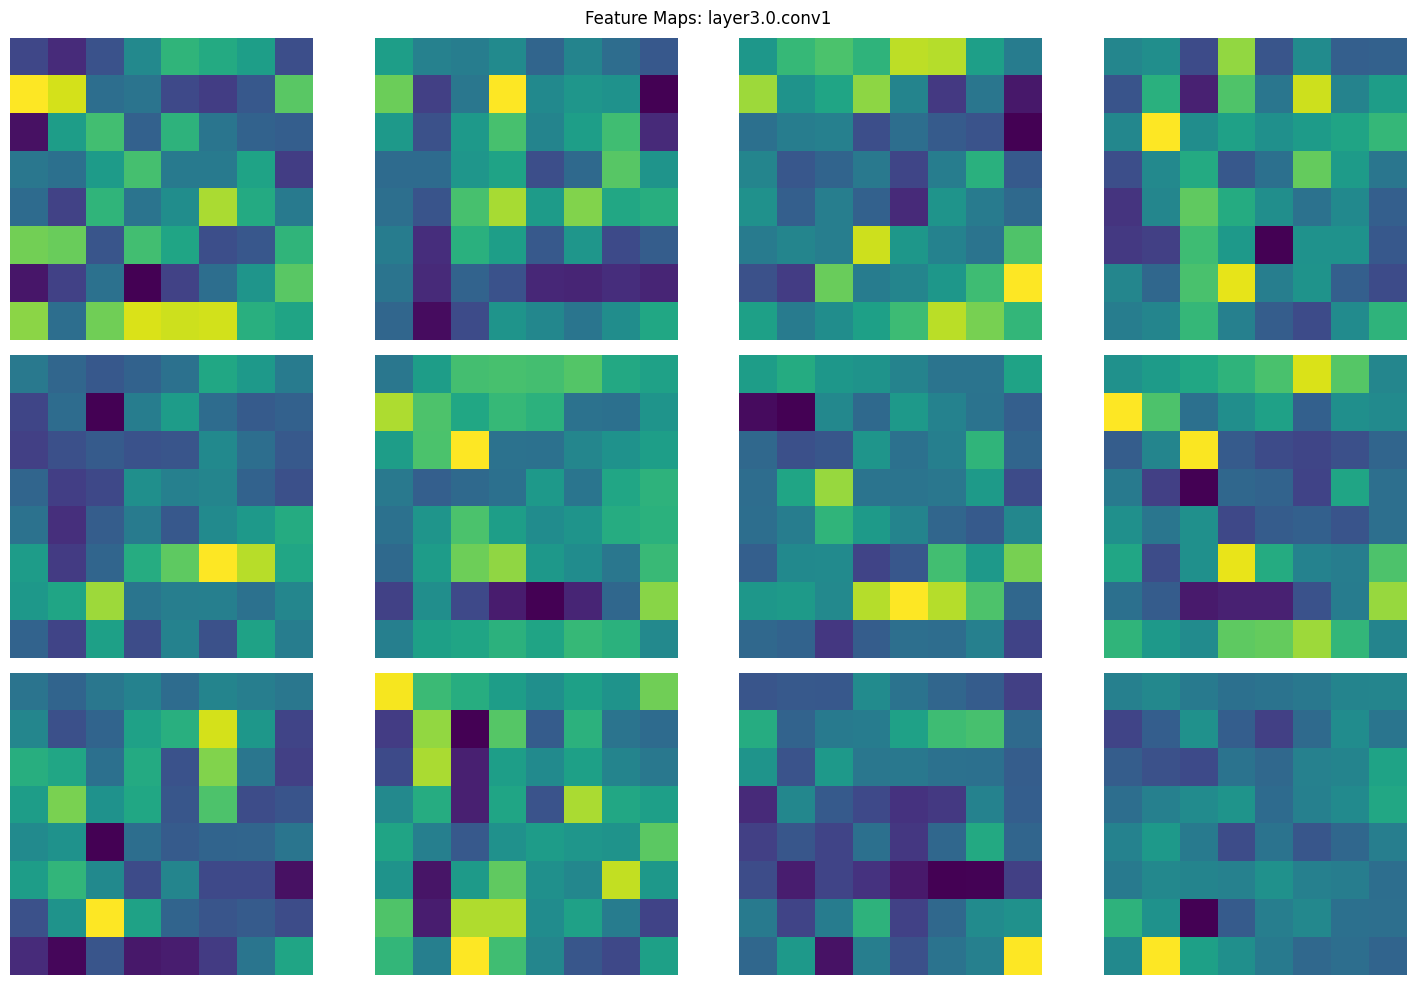

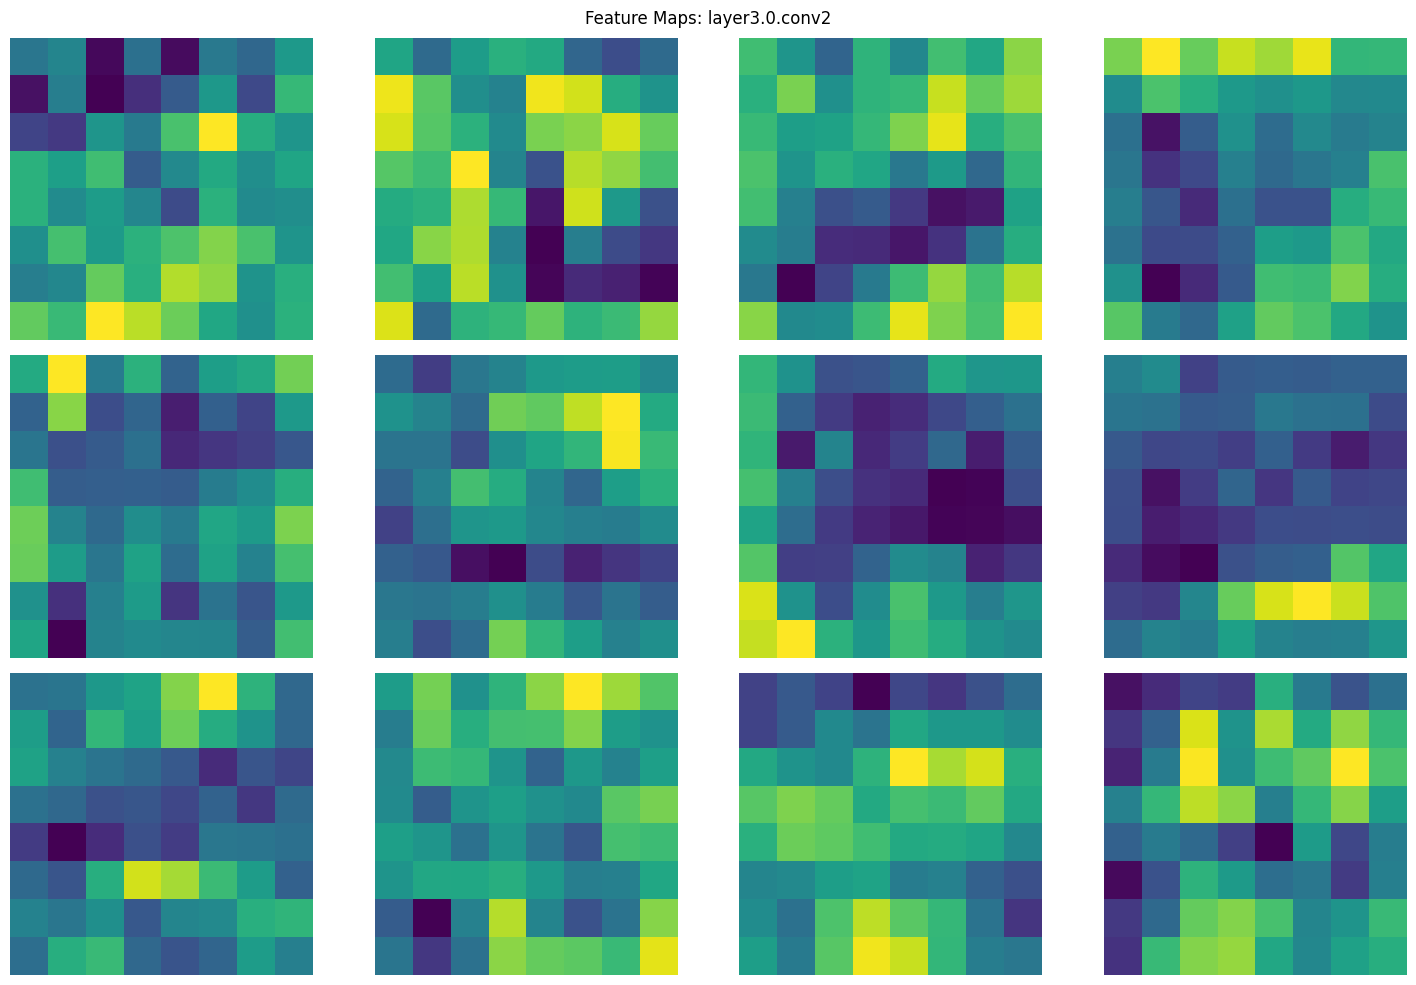

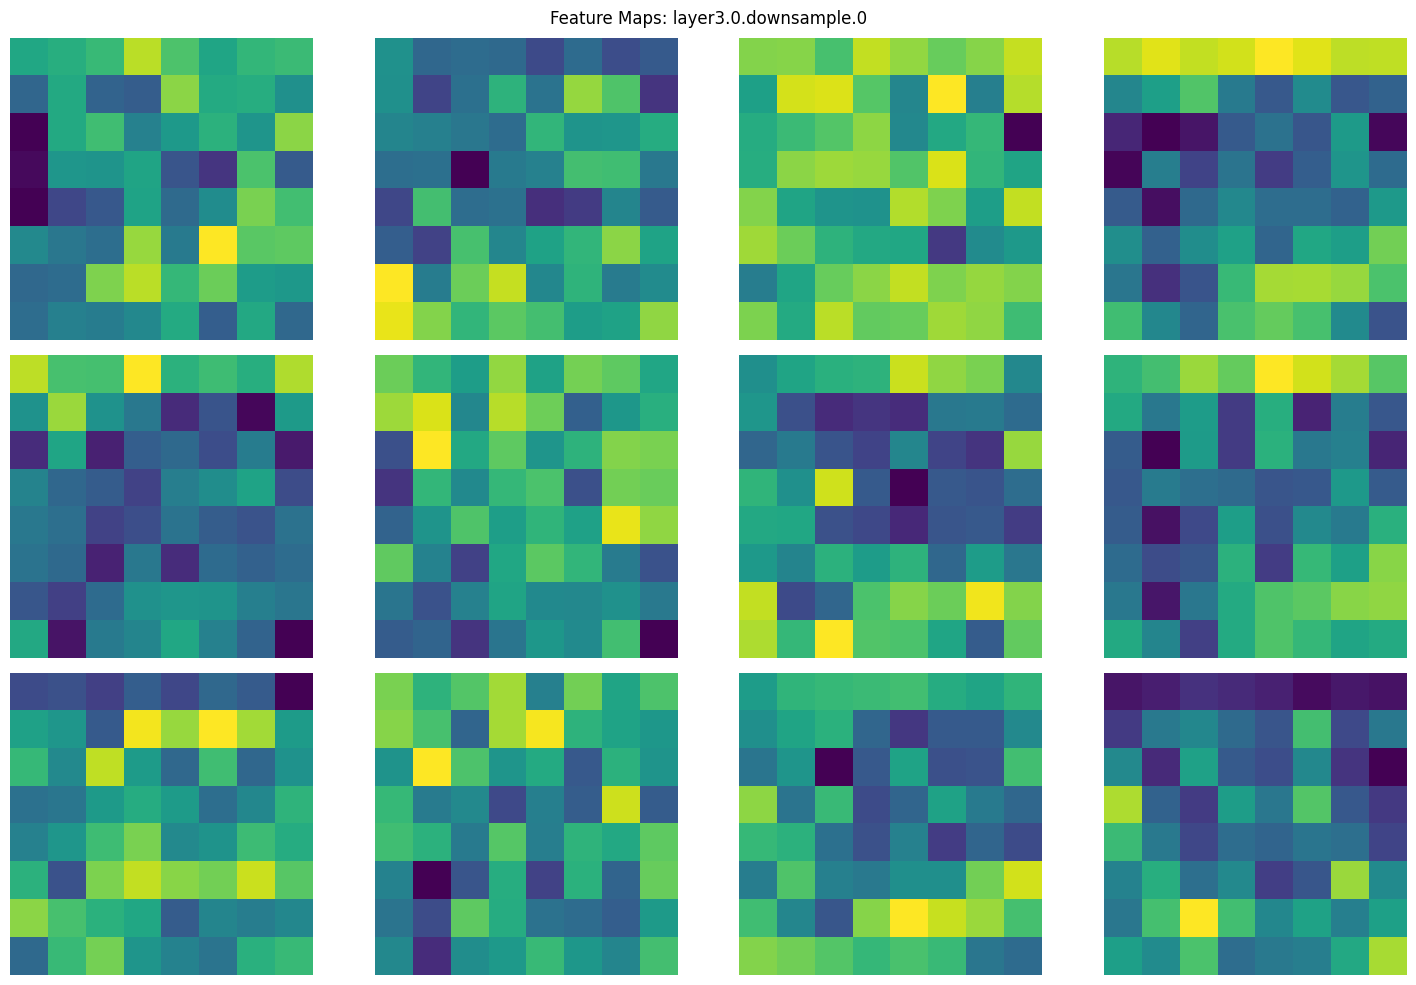

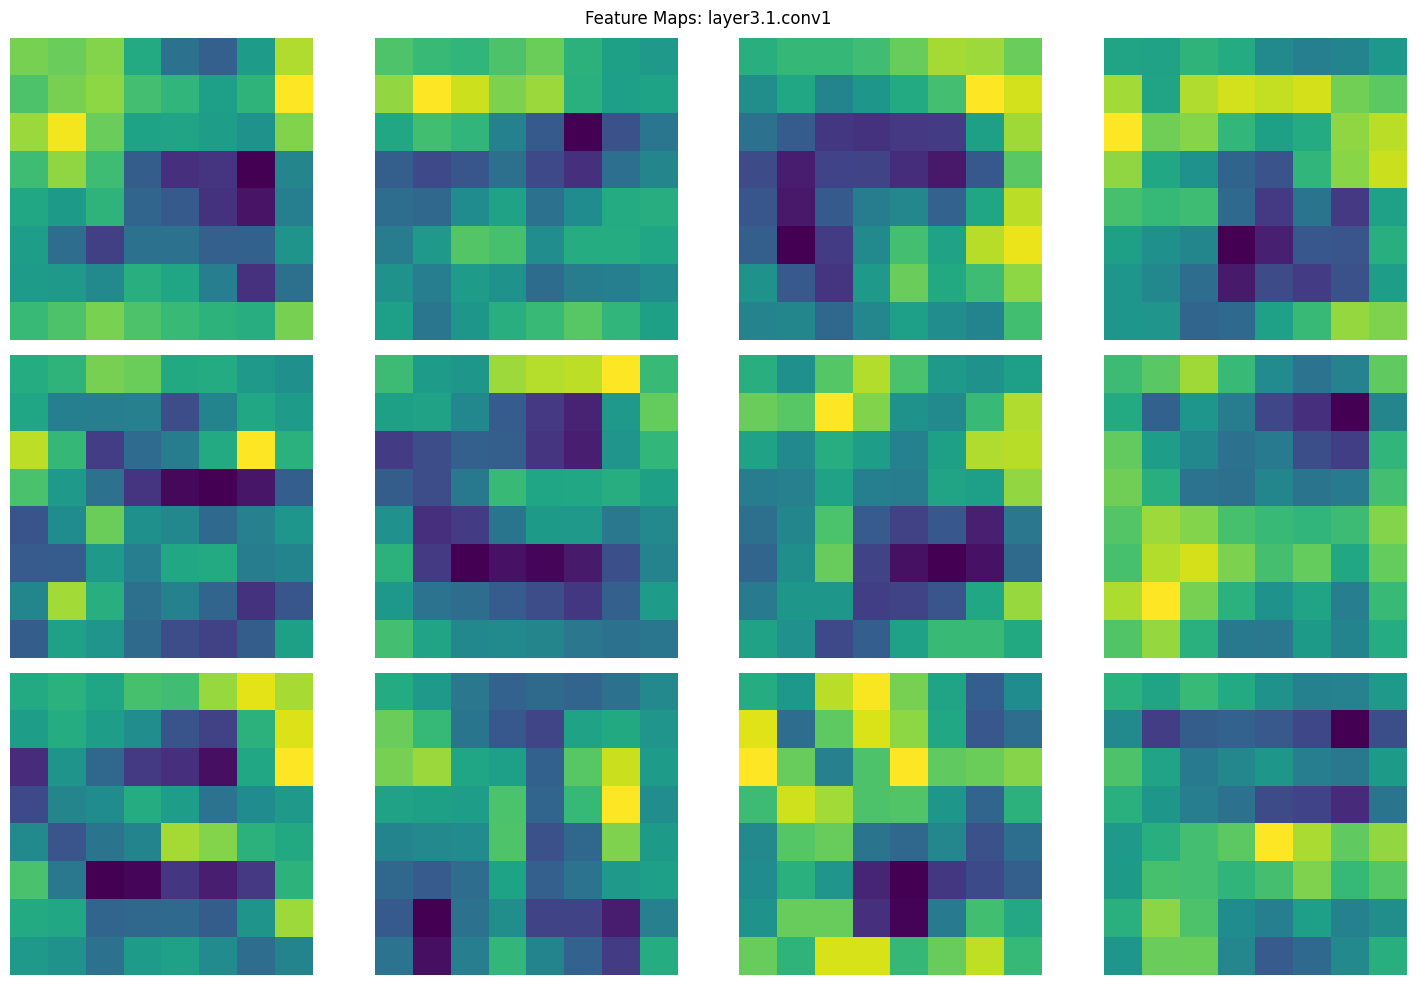

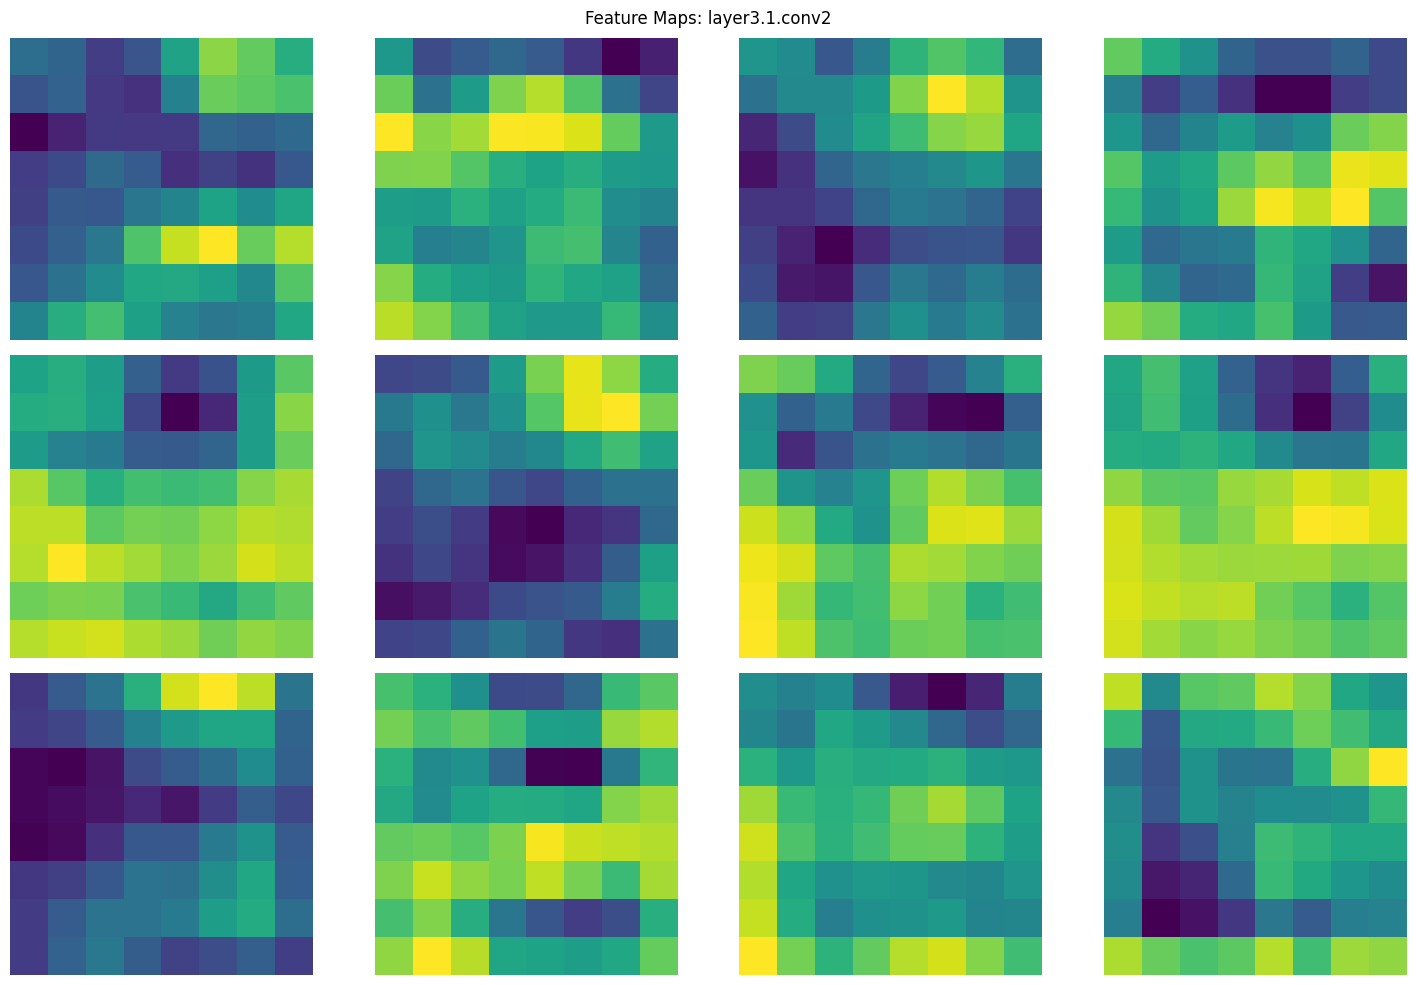

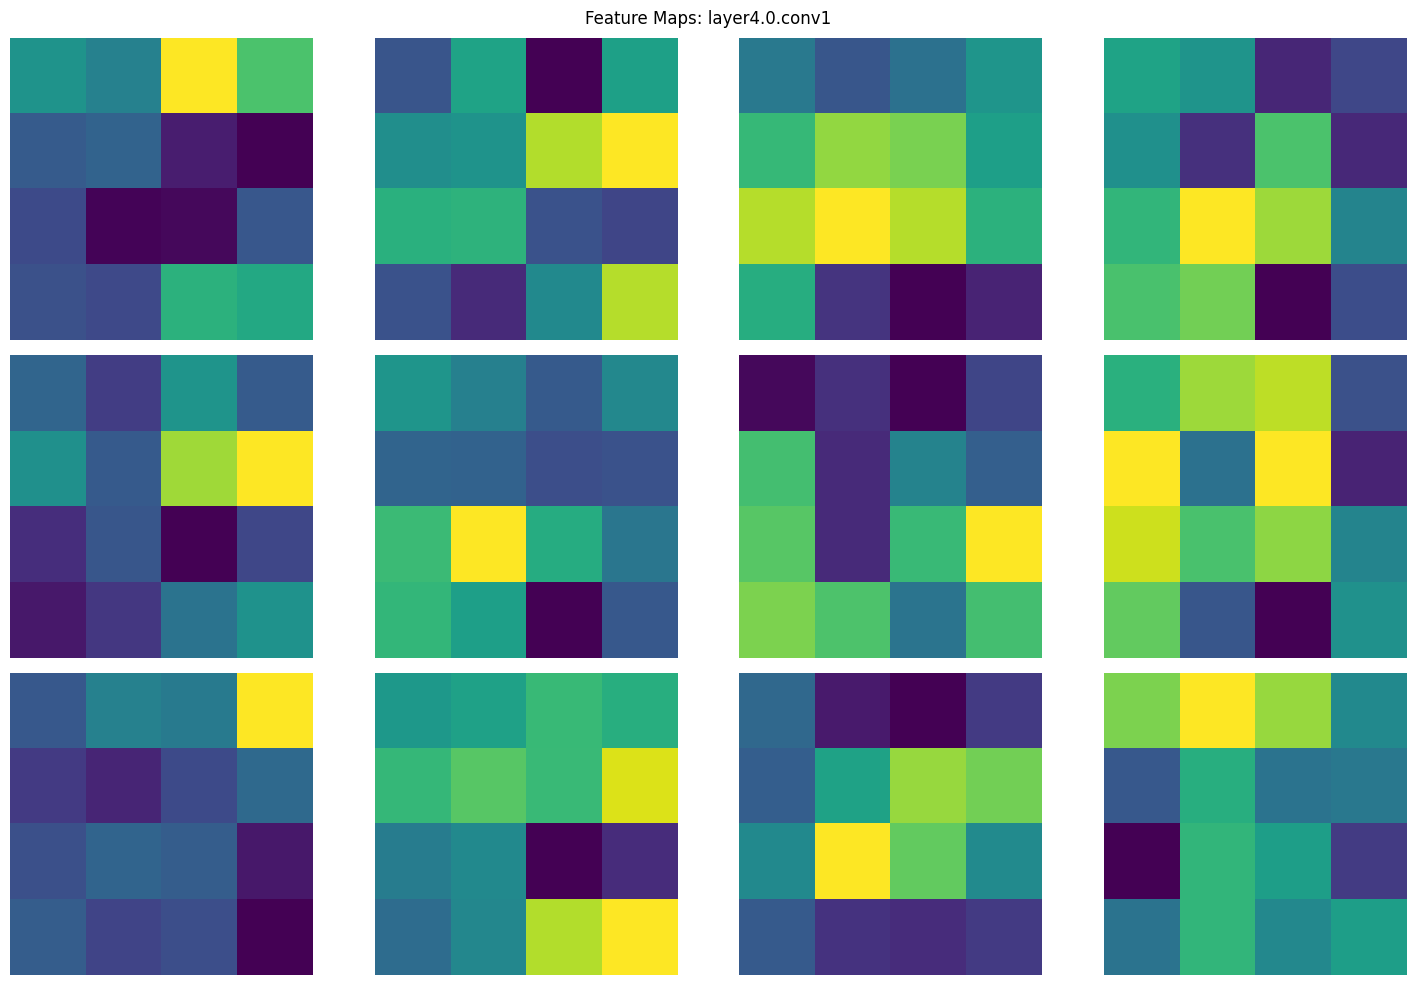

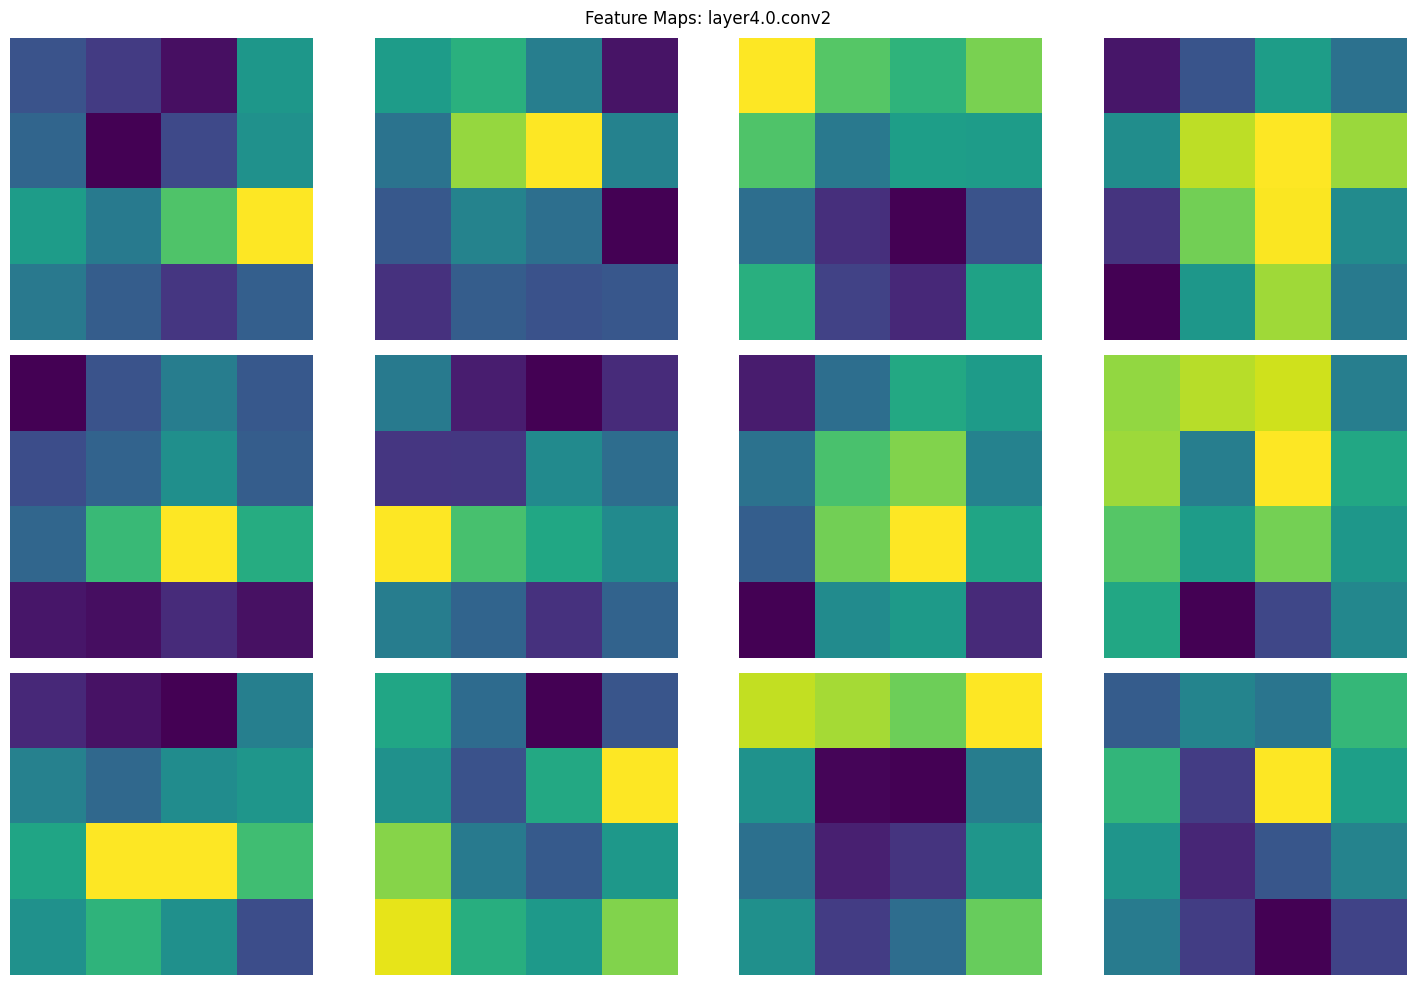

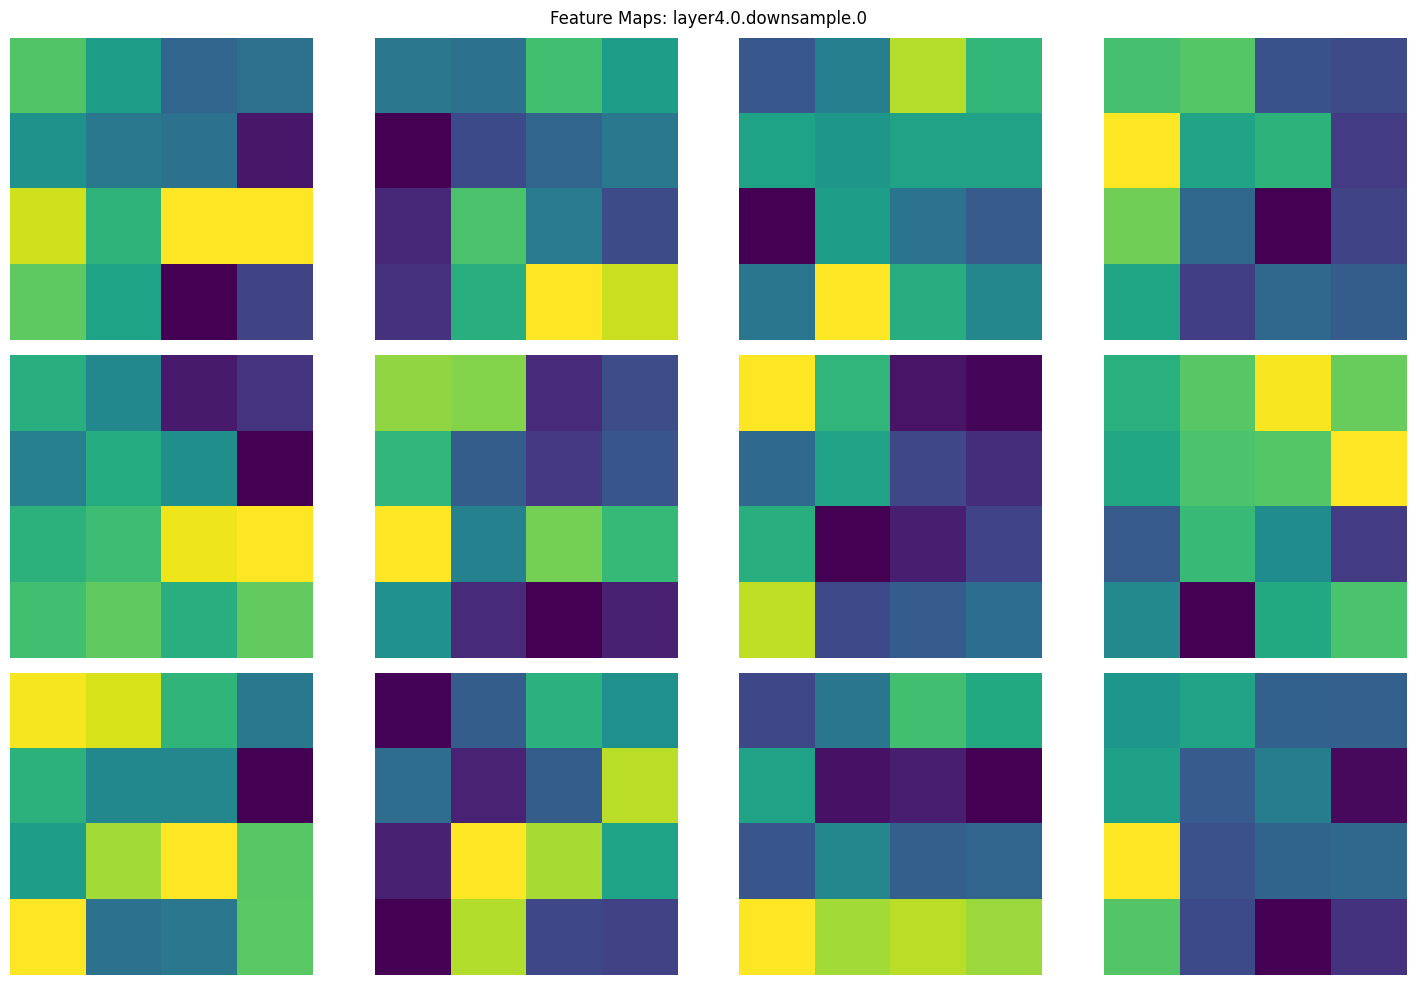

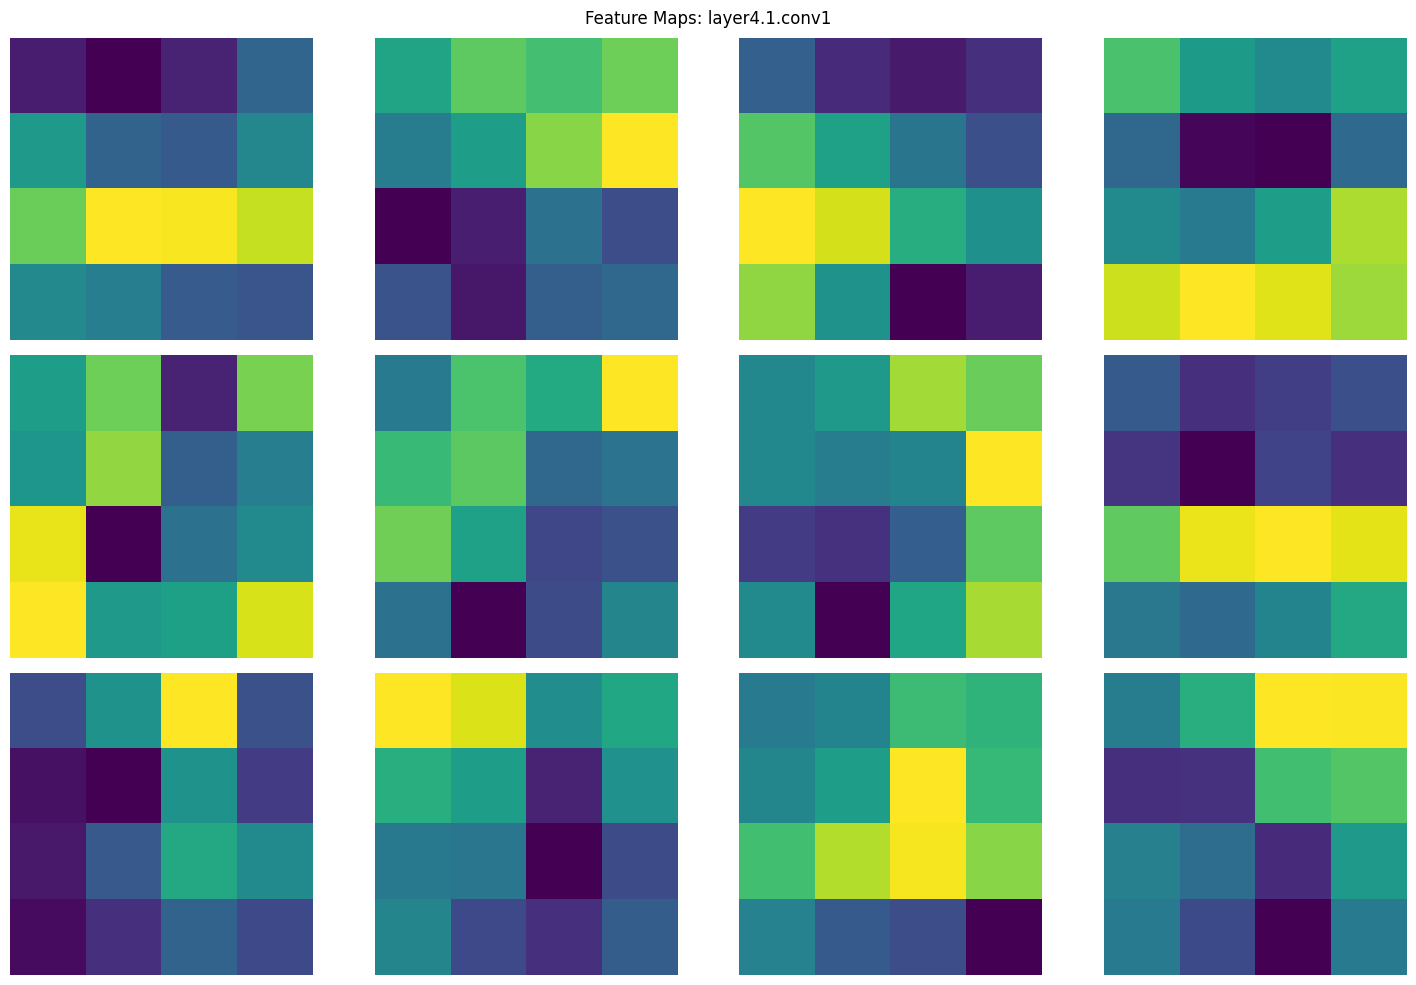

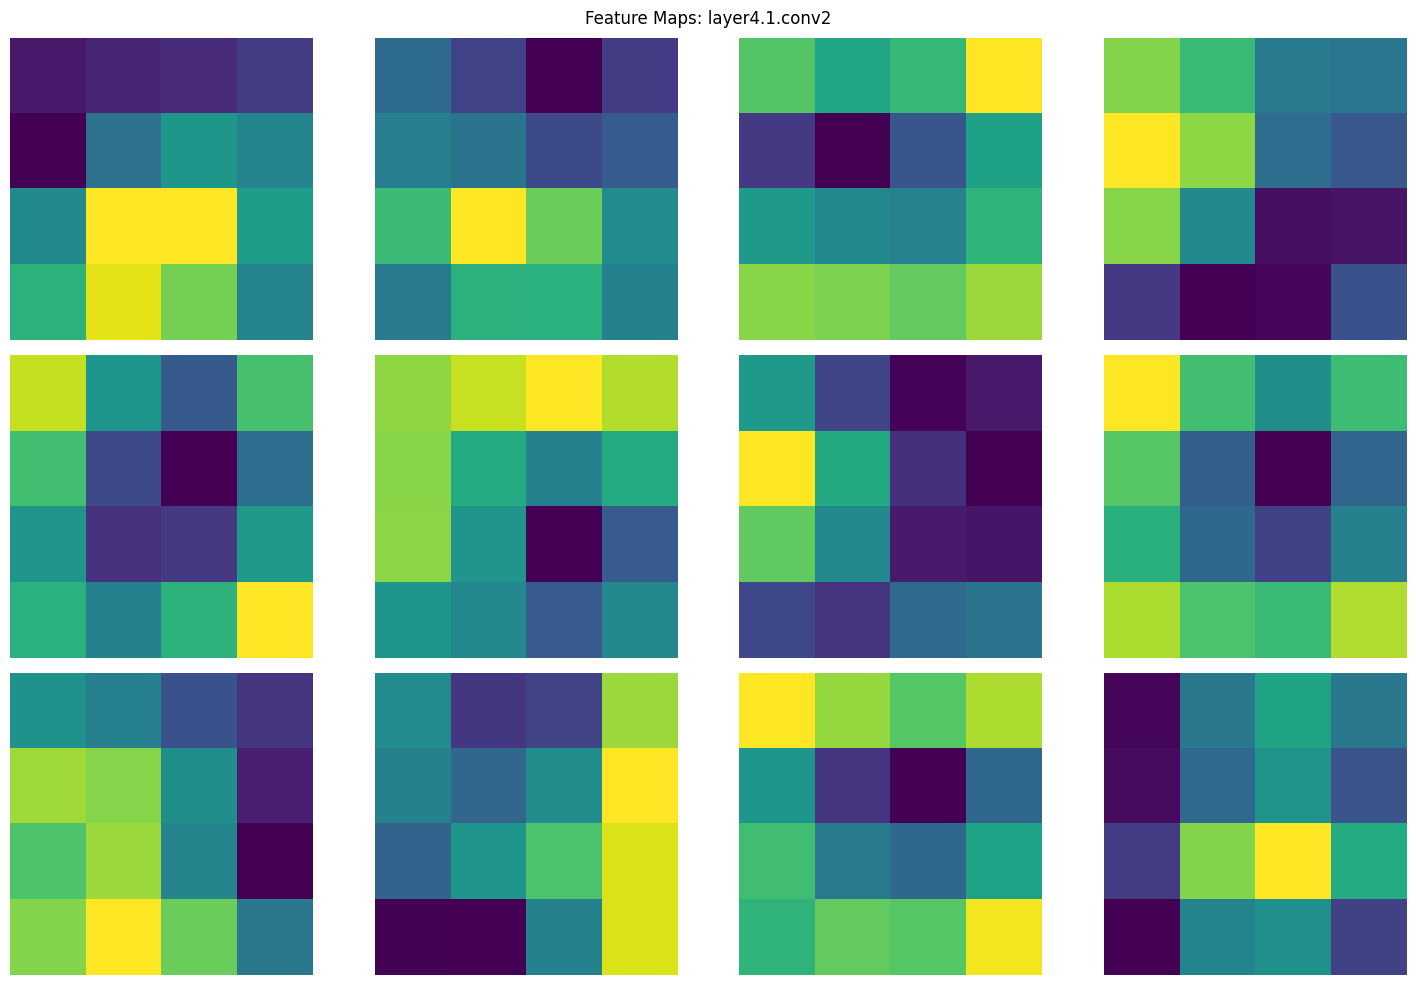

In [15]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot learning rate
plt.subplot(1, 3, 3)
plt.plot(history['lr'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize feature maps
print("\nVisualizing feature maps...")
visualize_feature_maps(model, val_loader, device)

## Conclusion
The notebook has:
1. Trained a ResNet-18 model on CIFAR-10
2. Monitored and visualized training progress
3. Saved the best model for later quantization
4. Visualized feature maps to understand model behavior

The trained model is saved at '../models/resnet18_cifar10.pth' and can be used for quantization in the next notebook.